In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imshow, imread
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score

Using TensorFlow backend.


In [2]:
train=pd.read_csv('D:\Chemical Compounds Deep Learning\musk_csv.csv')
print('The Train dataset has {} rows and {} columns' .format(train.shape[0], train.shape[1]))

The Train dataset has 6598 rows and 170 columns


In [3]:
train.head()

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,...,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
0,1,MUSK-211,211_1+1,46,-108,-60,-69,-117,49,38,...,-308,52,-7,39,126,156,-50,-112,96,1
1,2,MUSK-211,211_1+10,41,-188,-145,22,-117,-6,57,...,-59,-2,52,103,136,169,-61,-136,79,1
2,3,MUSK-211,211_1+11,46,-194,-145,28,-117,73,57,...,-134,-154,57,143,142,165,-67,-145,39,1
3,4,MUSK-211,211_1+12,41,-188,-145,22,-117,-7,57,...,-60,-4,52,104,136,168,-60,-135,80,1
4,5,MUSK-211,211_1+13,41,-188,-145,22,-117,-7,57,...,-60,-4,52,104,137,168,-60,-135,80,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 170 entries, ID to class
dtypes: int64(168), object(2)
memory usage: 8.6+ MB


In [5]:
train['molecule_name'].unique()[0:10]

array(['MUSK-211', 'MUSK-212', 'MUSK-213', 'MUSK-214', 'MUSK-215',
       'MUSK-217', 'MUSK-219', 'MUSK-224', 'MUSK-228', 'MUSK-238'],
      dtype=object)

In [6]:
train['class'].unique()

array([1, 0], dtype=int64)

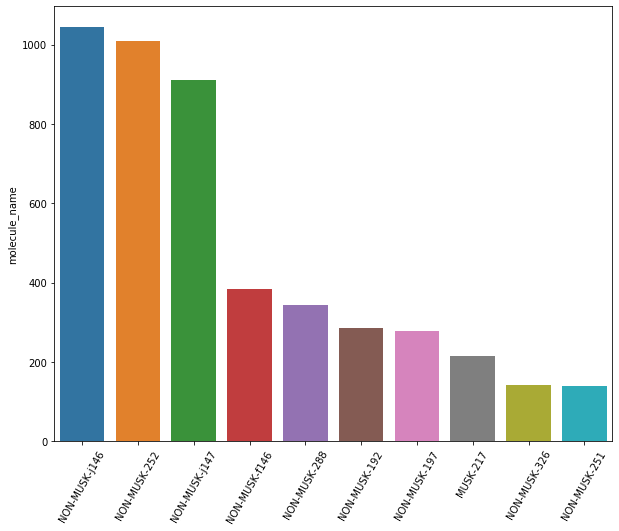

In [7]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=60)
a=train.molecule_name.value_counts()
a=a[:10]
sns.barplot(a.index, a)

In [8]:
# Create correlation matrix
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.92
to_drop = [column for column in upper.columns if any(upper[column] > 0.92)]
#to_drop = [column for column in corr.abs().columns if any(corr.abs()[column] > 0.92)]

we compare the correlation between features and remove one of two features that have a correlation higher than 0.9. So, when two features have high correlation, we can drop one of the two features.

In [9]:
train= train.drop(columns = to_drop)
train.shape

(6598, 117)

In [10]:
train.drop(['ID','conformation_name','molecule_name'],axis=1, inplace=True)
b=train['class']
b.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [11]:
a=a/255
a=a.astype('float')

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, b, test_size=0.20, random_state=42) 
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5278, 114), (1320, 114), (5278,), (1320,))

In [13]:
x_train=x_train.values.reshape(-1,19,6,1)
x_test=x_test.values.reshape(-1,19,6,1)
x_train.shape, x_test.shape

((5278, 19, 6, 1), (1320, 19, 6, 1))

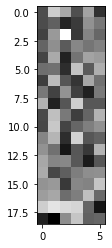

In [14]:
plt.imshow(x_train[589][:,:,0], cmap=plt.cm.binary)

In [15]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(19, 6, 1)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 17, 4, 32)         320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 2, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 1, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               57472     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [17]:
optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

In [18]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer=optimizer, metrics=['accuracy'])

In [19]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [20]:
earlystopping = EarlyStopping(patience=10)

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [22]:
callbacks = [earlystopping, learning_rate_reduction]

In [23]:
epochs=17

In [24]:
history = model.fit(x_train, y_train, 
                    batch_size=128, 
                    epochs=17, 
                    validation_data=(x_test, y_test))

Train on 5278 samples, validate on 1320 samples
Epoch 1/17
5278/5278 [==============================] - 3s 485us/step - loss: 1.9599 - accuracy: 0.8283 - val_loss: 0.1849 - val_accuracy: 0.9311
Epoch 2/17
5278/5278 [==============================] - 1s 268us/step - loss: 0.2947 - accuracy: 0.8984 - val_loss: 0.1721 - val_accuracy: 0.9318
Epoch 3/17
5278/5278 [==============================] - 1s 276us/step - loss: 0.2231 - accuracy: 0.9119 - val_loss: 0.1495 - val_accuracy: 0.9402
Epoch 4/17
5278/5278 [==============================] - 1s 264us/step - loss: 0.1882 - accuracy: 0.9263 - val_loss: 0.1282 - val_accuracy: 0.9515
Epoch 5/17
5278/5278 [==============================] - 1s 238us/step - loss: 0.1625 - accuracy: 0.9326 - val_loss: 0.1156 - val_accuracy: 0.9515
Epoch 6/17
5278/5278 [==============================] - 1s 249us/step - loss: 0.1600 - accuracy: 0.9346 - val_loss: 0.1081 - val_accuracy: 0.9568
Epoch 7/17
5278/5278 [==============================] - 1s 251us/step - loss

In [25]:
score=model.evaluate(x_test,y_test,verbose=0)
print(score)

[0.06152072325348854, 0.9727272987365723]


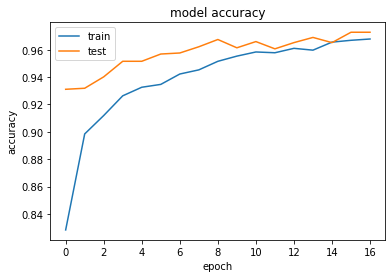

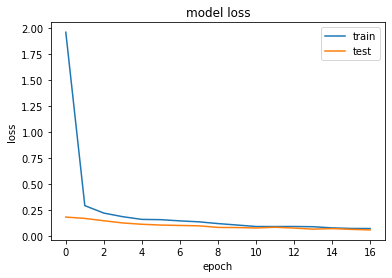

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [27]:
print(classification_report(y_test, model.predict_classes(x_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1111
           1       0.94      0.88      0.91       209

    accuracy                           0.97      1320
   macro avg       0.96      0.94      0.95      1320
weighted avg       0.97      0.97      0.97      1320



In [28]:
print("f1_score:",f1_score(y_test,model.predict_classes(x_test),))
print("recall:",recall_score(y_test,model.predict_classes(x_test),))
print("Validation Loss:",score[0])
print("Validation Accuracy:",score[1])

f1_score: 0.9108910891089109
recall: 0.8803827751196173
Validation Loss: 0.06152072325348854
Validation Accuracy: 0.9727272987365723


In [29]:
model.save('D:/Chemical Compounds Deep Learning/model2.h5')